In [1]:

import spatialdata as sd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_registration as ccf
from thalamus_merfish_analysis import ccf_transforms as ccft
%matplotlib inline

In [2]:
import nibabel

img = nibabel.load("/data/KimLabDevCCFv001/KimLabDevCCFv001_Annotations_ASL_Oriented_10um.nii.gz")

In [3]:
img.shape

(1320, 800, 1140)

In [4]:
imdata = np.array(img.dataobj).astype(int)

In [5]:
img_ccf = abc.get_ccf_labels_image(resampled=False)
img_ccf.shape


(1320, 800, 1140)

In [6]:
df = abc.get_combined_metadata(realigned=True)

In [7]:

coords = ['x_section', 'y_section', 'z_section']
slice_label = 'slice_int'
df[slice_label] = df['z_section'].apply(lambda x: int(x*10))

transforms_by_section = ccf.read_quicknii_file("/code/resources/quicknii_transforms_20231010.json", scale=25)
minmax = pd.read_csv("/code/resources/brain3_thalamus_coordinate_bounds.csv", index_col=0)

# load to spatialdata
norm_transform = ccft.get_normalizing_transform(
                                           min_xy=minmax.loc['min'].values, 
                                           max_xy=minmax.loc['max'].values, 
                                           flip_y=True)
cells_by_section = ccft.parse_cells_by_section(df, transforms_by_section, norm_transform, coords, slice_label=slice_label)
sdata = sd.SpatialData.from_elements_dict(cells_by_section)


In [8]:

# saving resampled images
img_transform = sd.transformations.Scale(10e-3*np.ones(3), 'xyz')
labels = sd.models.Labels3DModel.parse(imdata, dims='xyz', transformations={'ccf': img_transform})
sdata.add_labels('ccf_regions', labels)


INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('z', 'y', 'x').                           


In [13]:
from importlib import reload
reload(ccft)

<module 'thalamus_merfish_analysis.ccf_transforms' from '/root/capsule/code/thalamus_merfish_analysis/ccf_transforms.py'>

5.0

In [14]:

ngrid = 1100
nz = 76
z_res = 2
img_stack = np.zeros((ngrid, ngrid, nz), dtype=int)
for section in sdata.points.keys():
    i = int(np.rint(int(section)/z_res))
    target = sdata[section]
    source = sdata['ccf_regions']
    scale = 10e-3
    target_img, target_grid_transform = ccft.map_image_to_slice(sdata, imdata, source, target, scale=scale, ngrid=ngrid, centered=False)
    img_stack[:,:,i] = target_img.T

TypeError: '<' not supported between instances of 'int' and 'str'

In [31]:
import nibabel
nifti_img = nibabel.Nifti1Image(img_stack, affine=np.eye(4), dtype='int64')

# Save the NIfTI1Image object as .nii file
nibabel.save(nifti_img, '/scratch/labels.nii.gz')

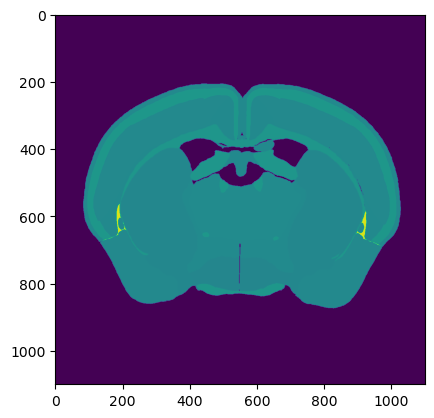

In [34]:
X = img_stack[:,:,int(np.rint(int(80)/z_res))].T
# X = np.where(X==0, np.nan, X)
plt.imshow(X)


In [22]:
th_top_level = ['ZIC', 'CZI', 'Th']

import networkx as nx
import pandas as pd

devccf_index = pd.read_csv("/data/KimLabDevCCFv001/KimLabDevCCFv001_MouseOntologyStructure.csv",
                           dtype={'ID':str, 'Parent ID':str})
# some quotes have both single and double
for x in ['Acronym','Name']:
    devccf_index[x] = devccf_index[x].str.replace("'","")
    
g = nx.from_pandas_edgelist(devccf_index, source='Parent ID', target='ID', 
                            create_using=nx.DiGraph())
devccf_index = devccf_index.set_index('Acronym')
th_ids = list(set.union(*(set(nx.descendants(g, devccf_index.loc[x, 'ID'])) 
                   for x in th_top_level)))
th_names = devccf_index.reset_index().set_index('ID').loc[th_ids, 'Acronym']

In [23]:
len(th_ids)

122

In [32]:
devccf_index = pd.read_csv("/data/KimLabDevCCFv001/KimLabDevCCFv001_MouseOntologyStructure.csv",
                           dtype={'ID':int, 'Parent ID':str})
# some quotes have both single and double
for x in ['Acronym','Name']:
    devccf_index[x] = devccf_index[x].str.replace("'","")
    


In [35]:
pd.Series([0,1]).map(
    devccf_index.set_index('ID').to_dict())

0    NaN
1    NaN
dtype: object